# 准备数据集

流程如下：
1. 分割图片
2. 提取特征
3. 准备数据集
4. 回归预测

In [39]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append(r'E:\WPSSync\Projects\SimulationForPinhole\utils')
import cv2
import numpy as np
from PIL import Image
from skimage.transform import warp, SimilarityTransform
from utils.findBrightRegions import findBrightRegions

def extract_and_square(image_path, coordinates):
    # 读取图像
    image = Image.open(image_path)

    # 获取四个点的坐标
    src = np.array(coordinates)

    # 定义目标正方形的坐标
    dst = np.array([[0, 0], [0, 5000], [5000, 5000], [5000, 0]])

    # 计算透视变换矩阵
    transform = SimilarityTransform()
    transform.estimate(src, dst)

    # 进行透视变换
    warped = warp(np.array(image), transform.inverse, output_shape=(5000, 5000))

    # 将变换后的图像转换为PIL图像对象
    squared_image = Image.fromarray((warped * 255).astype(np.uint8))

    return squared_image


# 读入图片并提取指定区域并矫正为正方形
image_path1 = "Dataset/NewPinholeSampleImage/Image10_100.bmp"
image_path2 = "Dataset/NewPinholeSampleImage/Image110_200.bmp"

fig1 = [[1052, 868], [1002, 2384], [2543, 2405], [2550, 860]]
fig2 = [[2554, 886], [2539, 2433], [4116, 2446], [4079, 891]]
fig3 = [[1053, 890], [1005, 2408], [2539, 2428], [2565, 881]]
fig4 = [[2506, 2428], [4098, 2431], [4075, 862], [2526, 878]]

squared_region1 = extract_and_square(image_path1, fig1)
squared_region1.save("Dataset/NewPinholeSampleImage/region1.bmp")
squared_region2 = extract_and_square(image_path1, fig2)
squared_region2.save("Dataset/NewPinholeSampleImage/region2.bmp")
squared_region3 = extract_and_square(image_path2, fig3)
squared_region3.save("Dataset/NewPinholeSampleImage/region3.bmp")
squared_region4 = extract_and_square(image_path2, fig4)
squared_region4.save("Dataset/NewPinholeSampleImage/region4.bmp")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
# 文件夹路径
folder_path = "Dataset/NewPinholeSampleImage"
rawimgs_path = os.path.join(folder_path, "raw")
output_folder = os.path.join(folder_path, "cropped_imgs")

# conditions.txt存在的话，就读入
txt_file_path = os.path.join(rawimgs_path, "conditions.txt")
if os.path.exists(txt_file_path):
    # 如果文件存在，则读取文件内容并保存到字符串中
    with open(txt_file_path, 'r') as file:
        file_content = file.read()
    attribute_dict = {}
    attributes = file_content.split("-")
    # 解析每个属性
    for attribute in attributes:
        key, value = attribute.split("_")
        attribute_dict[key] = value
    # 输出读取到的文件内容
    print("实验条件：\n")
    for key, value in attribute_dict.items():
        print(f"  {key}: {value}")
else:
    print("实验条件相关文件不存在")

实验条件：

  ImagingDistance: 204
  ExposureTime: 10000
  PowerdividedbyArea: 757.5
  Fnumber: 1.4
  Focal: 8
  CMOSPixelSize: 2.4
  CMOSQE: 0.5


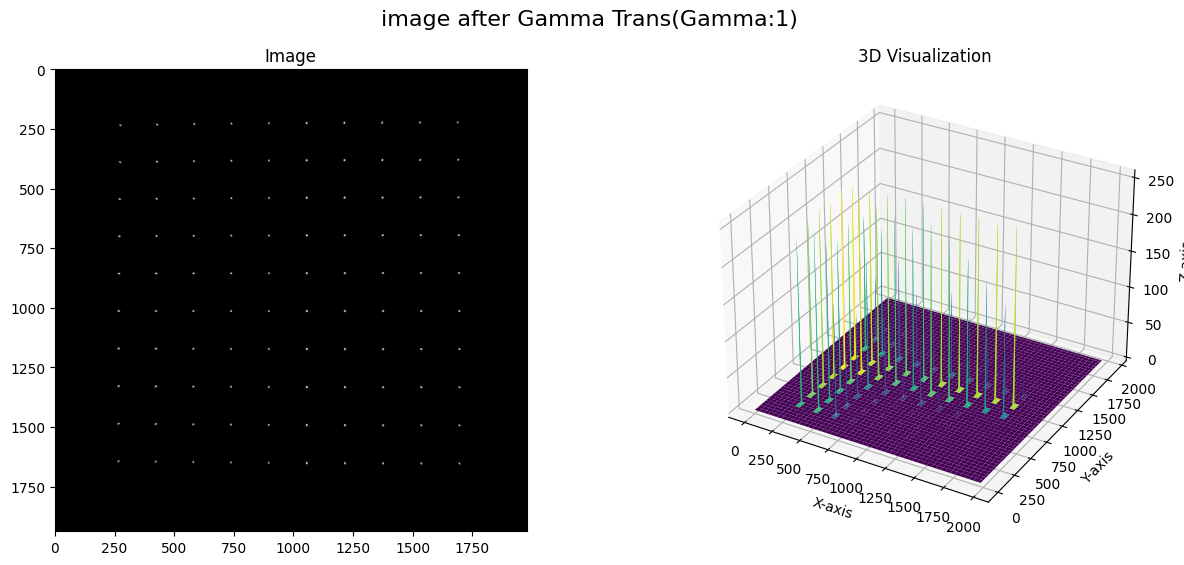

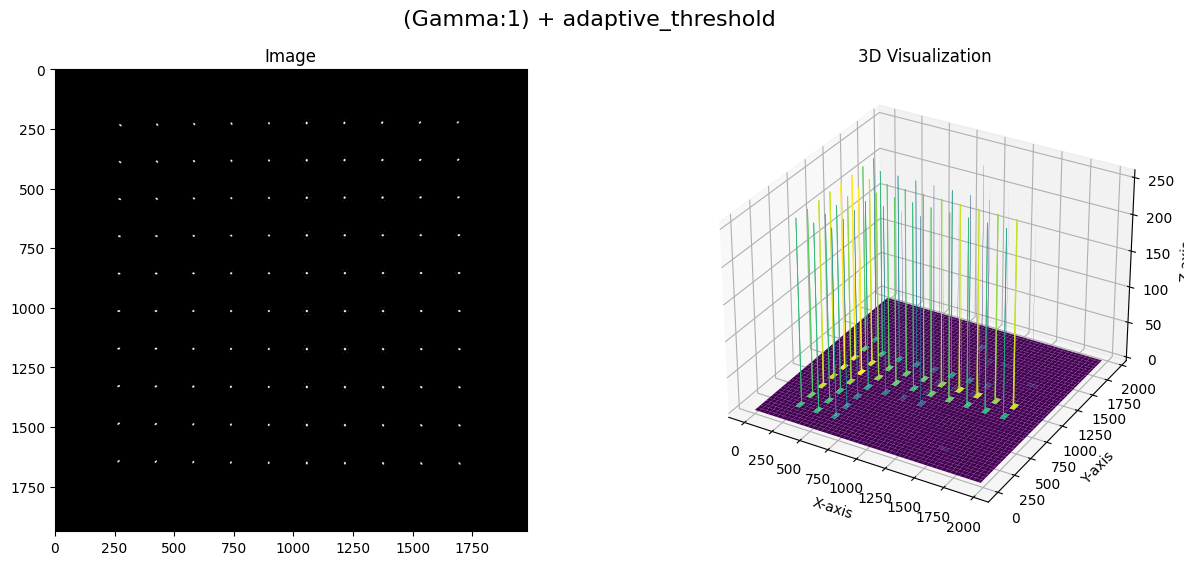

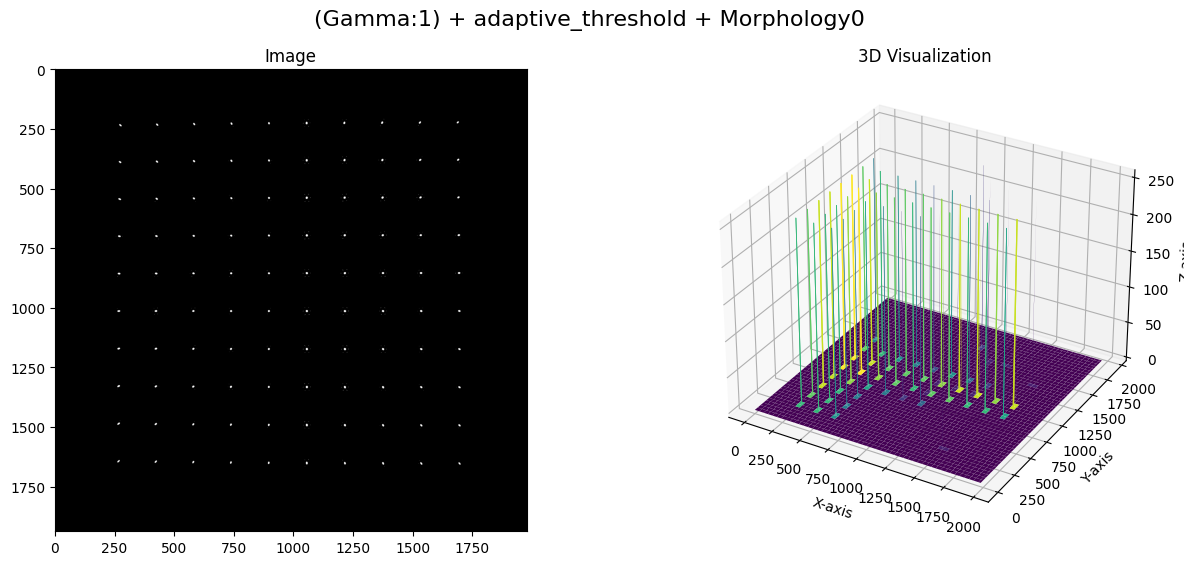

In [71]:
from utils.findBrightRegions import findBrightRegions
image_path = r"E:\WPSSync\Projects\SimulationForPinhole\Dataset\NewPinholeSampleImage\raw\160_200.bmp"
# 2. 读取图像，寻找区域
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
# 寻找亮区域
num_labels, labels, stats, centroids = findBrightRegions(image, attribute_dict)

In [68]:
# 获取图像的边长, 一张图中可以均分为10个竖条区域，区域内的针孔大小相同
image_width = image.shape[0]
region_width = image_width // 10

# 过滤面积超出阈值的连通区域
min_area_threshold = 0 if int(attribute_dict["ExposureTime"]) < 1000 else 5
max_area_threshold = 1000
print(f"min_area_threshold = {min_area_threshold}")
print(f"max_area_threshold = {max_area_threshold}")

filtered_labels = [
    label
    for label, stat in enumerate(stats[1:], start=1)
    if min_area_threshold < stat[4] < max_area_threshold
]
# 可视化找到的亮区域结果
mask = np.zeros_like(image)
for label in filtered_labels:
    mask[labels == label] = 255
    # 在图像上绘制文本, 标注面积
    area = stats[label][4]
    text = f"Area:{area}"
    text_size, _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
    # 计算文本框的位置
    centroid = (int(centroids[label][0]- text_size[0]/2), int(centroids[label][1]+ 1.2*text_size[1]))
    # 绘制文本
    cv2.putText(mask, text, centroid, cv2.FONT_HERSHEY_SIMPLEX, 1, 255, 2)
    
rgba_array = np.zeros((*mask.shape, 4), dtype=np.uint8)
rgba_array[:, :, 0] = mask  # 红色通道
rgba_array[:, :, 3] = 100  # 透明度
rgba_mask = Image.fromarray(rgba_array, "RGBA")
rgba_image = Image.fromarray(image).convert("RGBA")
rgba_result = Image.alpha_composite(rgba_image, rgba_mask)

rgba_result_name = "Area Result of " + os.path.basename(image_path)
output_path = os.path.join(folder_path, "result", rgba_result_name)
rgba_result.save(output_path, "BMP")

stats = stats[filtered_labels, :]

min_area_threshold = 5
max_area_threshold = 1000


In [81]:
# 3.裁剪区域，保存和记录特征值
for stat in stats:
    # 获取连通区域的坐标信息,x,y是leftTop点坐标
    x, y, w, h, area = stat[0], stat[1], stat[2], stat[3], stat[4]

    from utils.getDiameterfromPosition import getDiameterfromPosition

    # 根据位置判断直径
    min_diameter = int(os.path.basename(image_path).split("_")[0])
    Diameter = getDiameterfromPosition(x, region_width, min_diameter)

    # 裁剪图像
    # # 根据长宽裁剪
    # cropped_region = image[y - 2 * h : y + 3 * h, x - 2 * w : x + 3 * w]
    # 按正方形裁剪
    length = 10* max(w, h)
    center = [x + w / 2, y + h / 2]
    cropped_region = image[
        int(center[1] - length / 2) : int(center[1] + length / 2),
        int(center[0] - length / 2) : int(center[0] + length / 2)
    ]

    # 计算最大值、最小值、平均值、中位数和方差
    max_value = np.max(cropped_region)
    min_value = np.min(cropped_region)
    mean_value = np.mean(cropped_region)
    median_value = np.median(cropped_region)
    variance_value = np.var(cropped_region)

    # 打开annotation.cvs记录
    with open(folder_path + "/annotation.csv", "r") as file:
        lines = file.readlines()
        last_image_id = 0
        if len(lines) > 1:  # 确保文件中有至少两行（包括标题行和数据行）
            last_line = lines[-1].strip()  # 获取最新一行并去除首尾空白
            last_image_id = int(last_line.split(",")[0])

    with open(folder_path + "/annotation.csv", "a") as file:
        file.write(
            f"{last_image_id + 1},"
            f"{attribute_dict['ImagingDistance']},"
            f"{attribute_dict['ExposureTime']},"
            f"{attribute_dict['PowerdividedbyArea']},"
            f"{attribute_dict['Fnumber']},"
            f"{attribute_dict['Focal']},"
            f"{attribute_dict['CMOSPixelSize']},"
            f"{attribute_dict['CMOSQE']},"
            f"{w},"
            f"{h},"
            f"{area},"
            # 图像的灰度分布信息：最值 平均值 中位数 方差
            f"{max_value:.4f},"
            f"{min_value:.4f},"
            f"{mean_value:.4f},"
            f"{median_value:.4f},"
            f"{variance_value:.4f},"
            f"{x},"
            f"{y},"
            f"{Diameter}\n"
        )
    # 保存裁剪的图像
    cv2.imwrite(
        os.path.join(output_folder, f"{last_image_id + 1}.png"),
        cropped_region,
    )

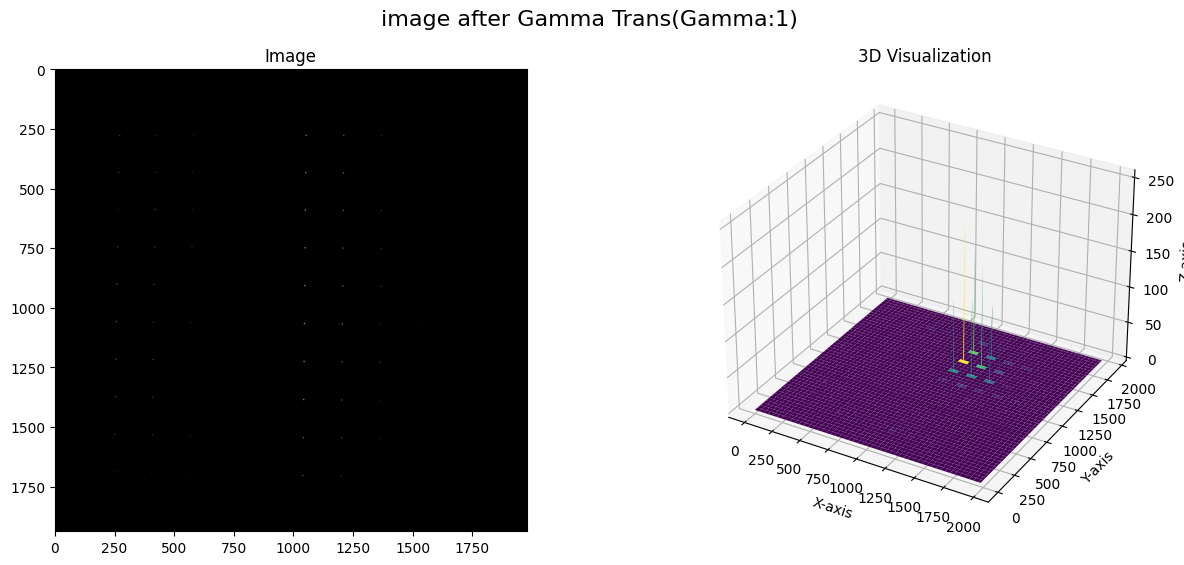

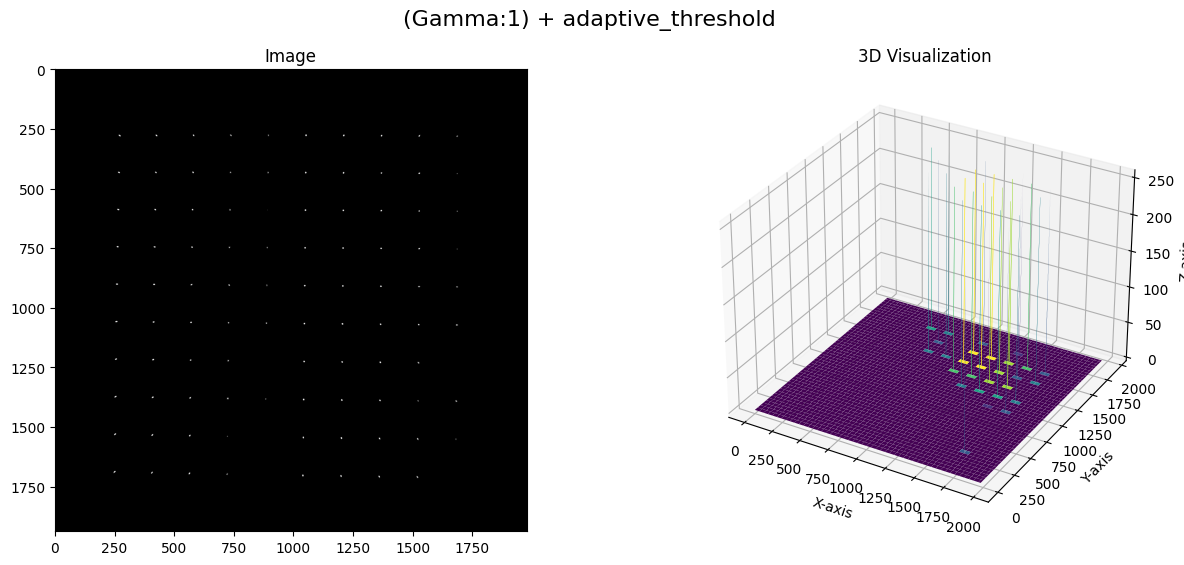

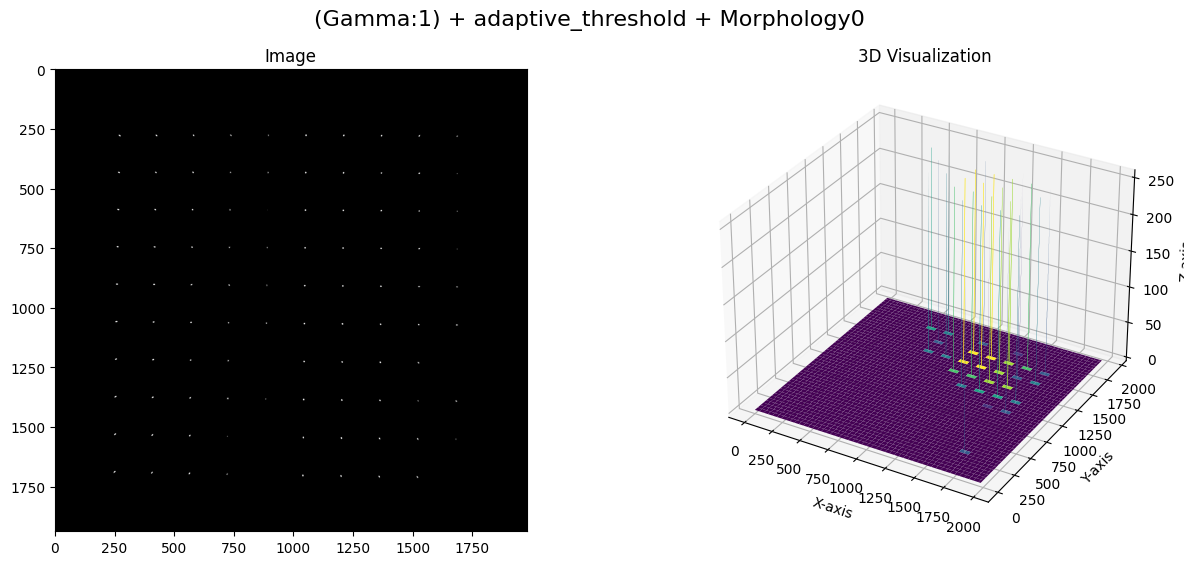

min_area_threshold = 5
max_area_threshold = 1000


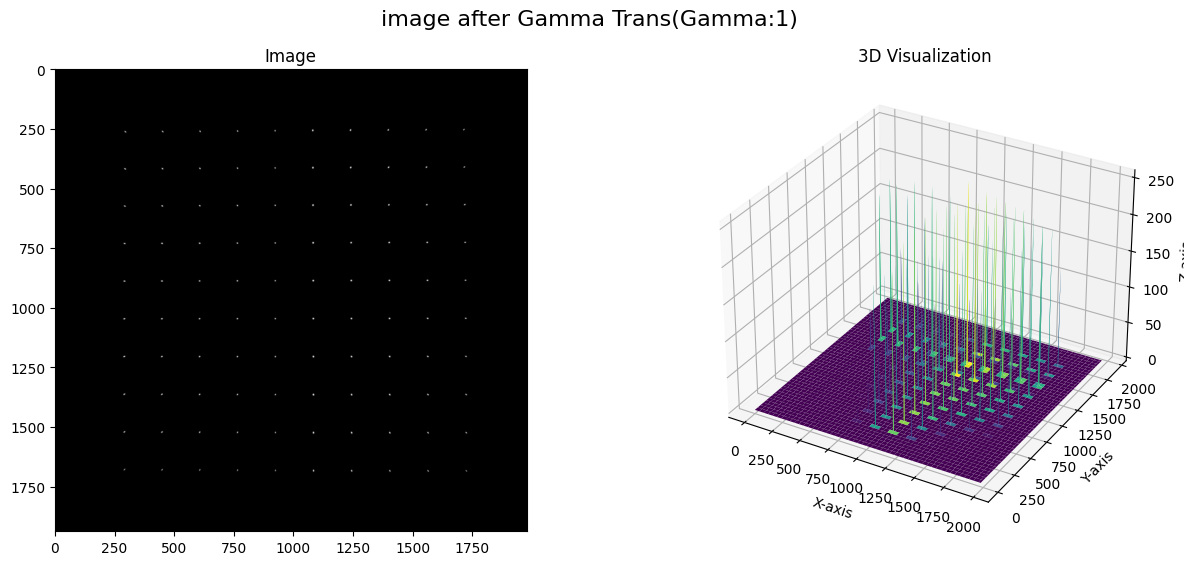

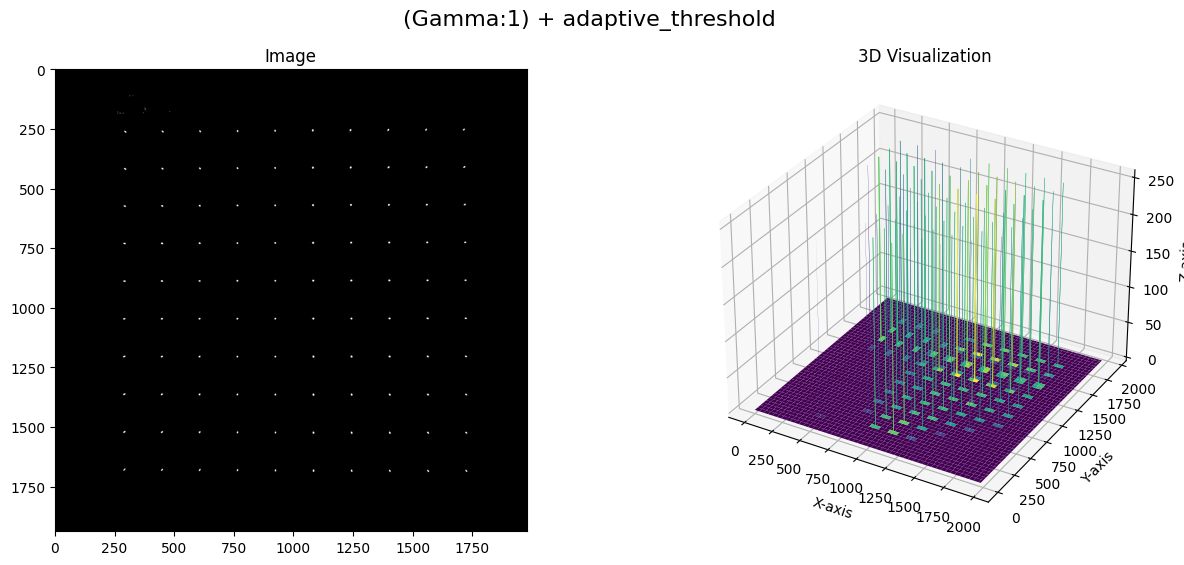

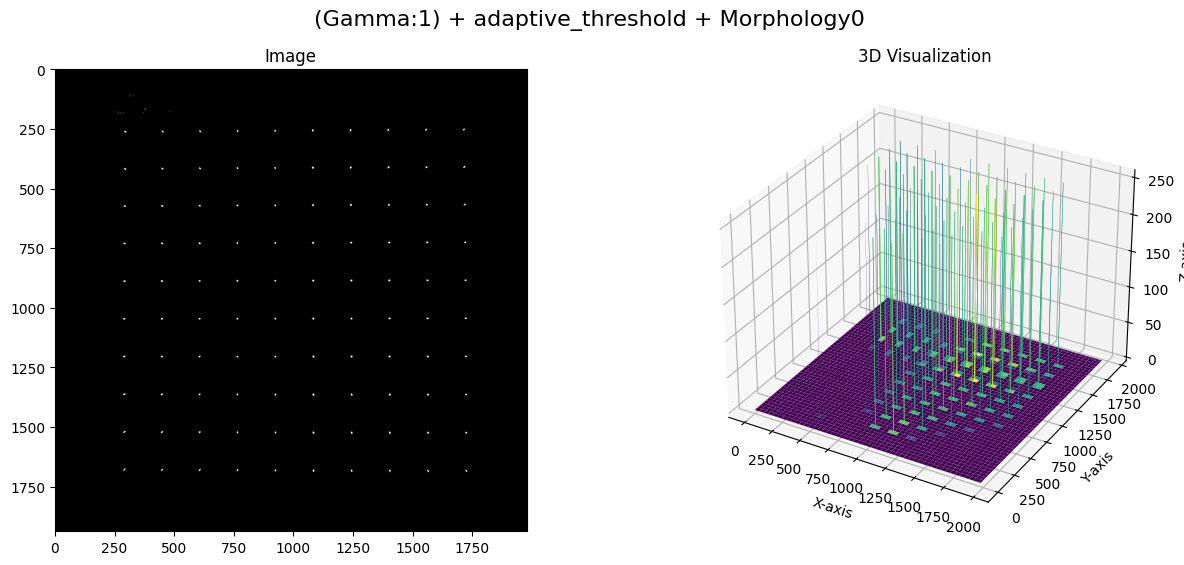

min_area_threshold = 5
max_area_threshold = 1000


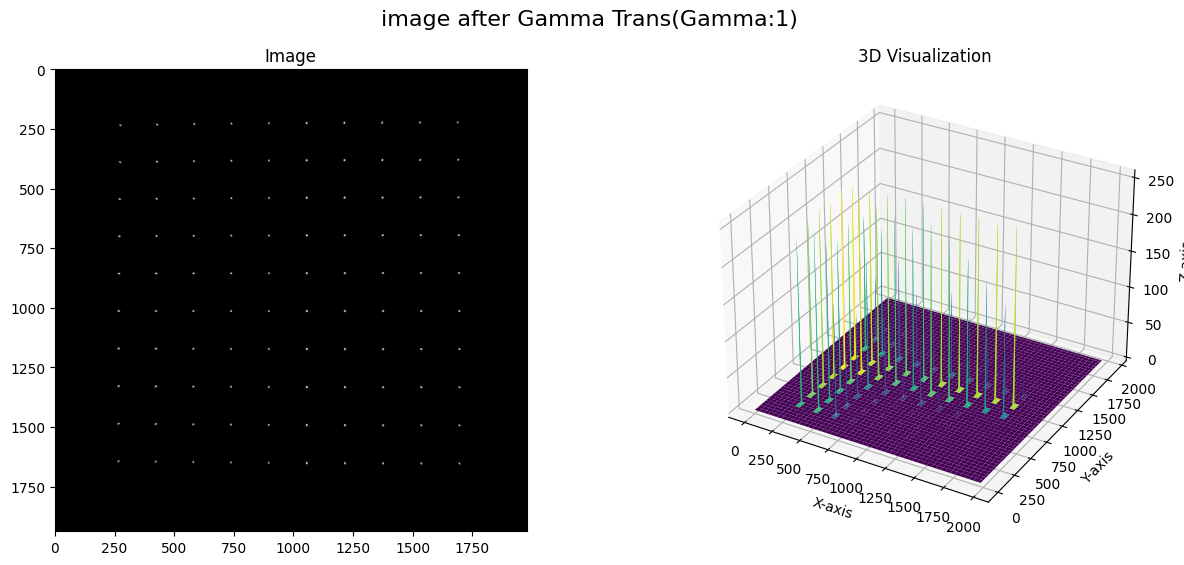

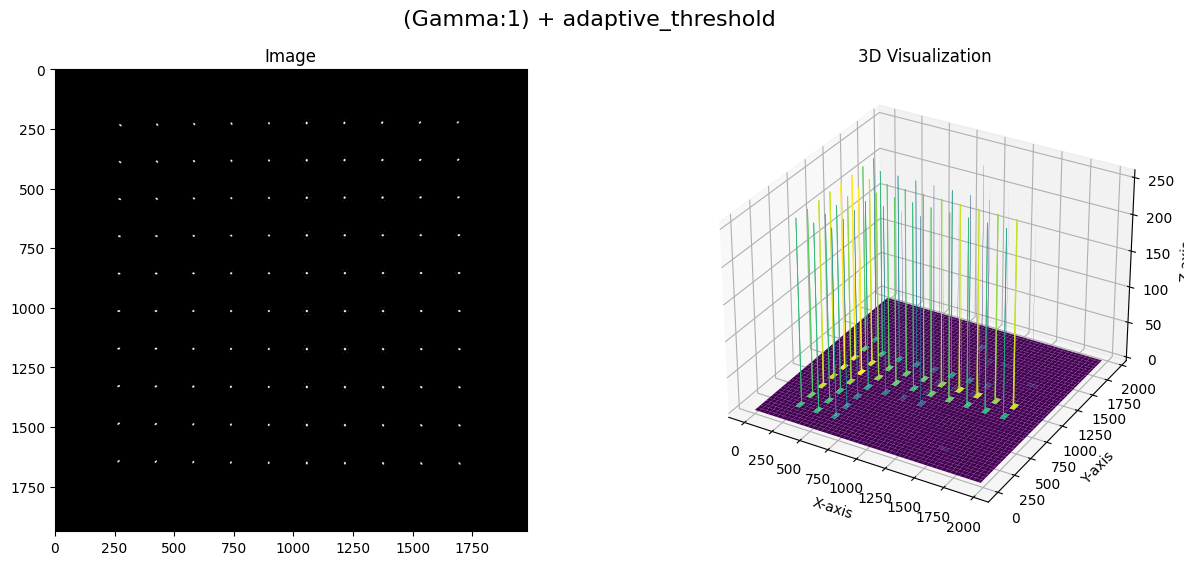

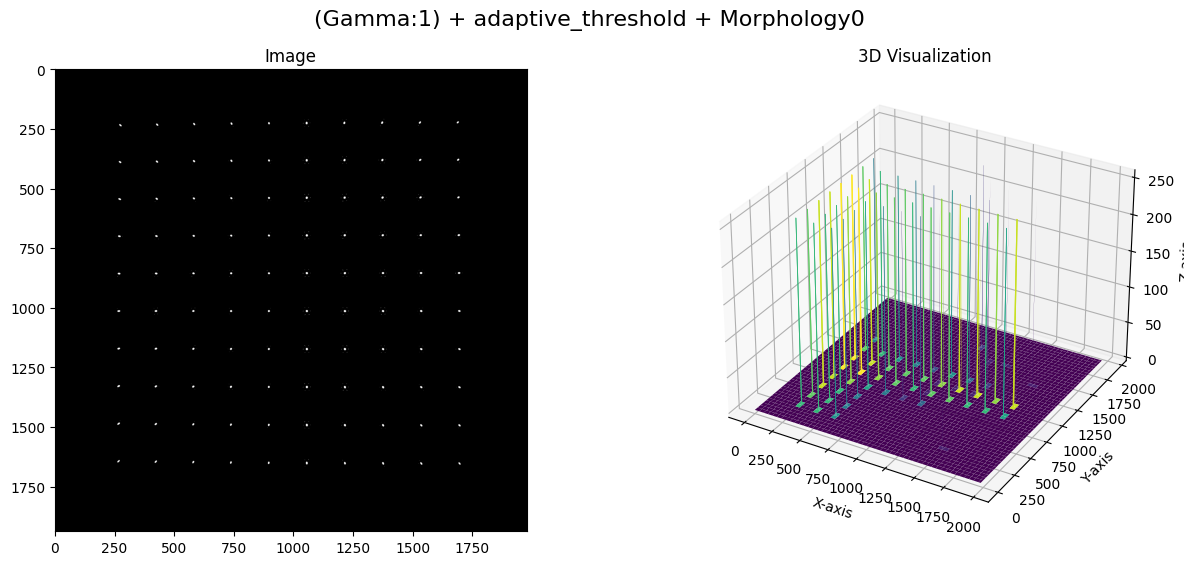

min_area_threshold = 5
max_area_threshold = 1000


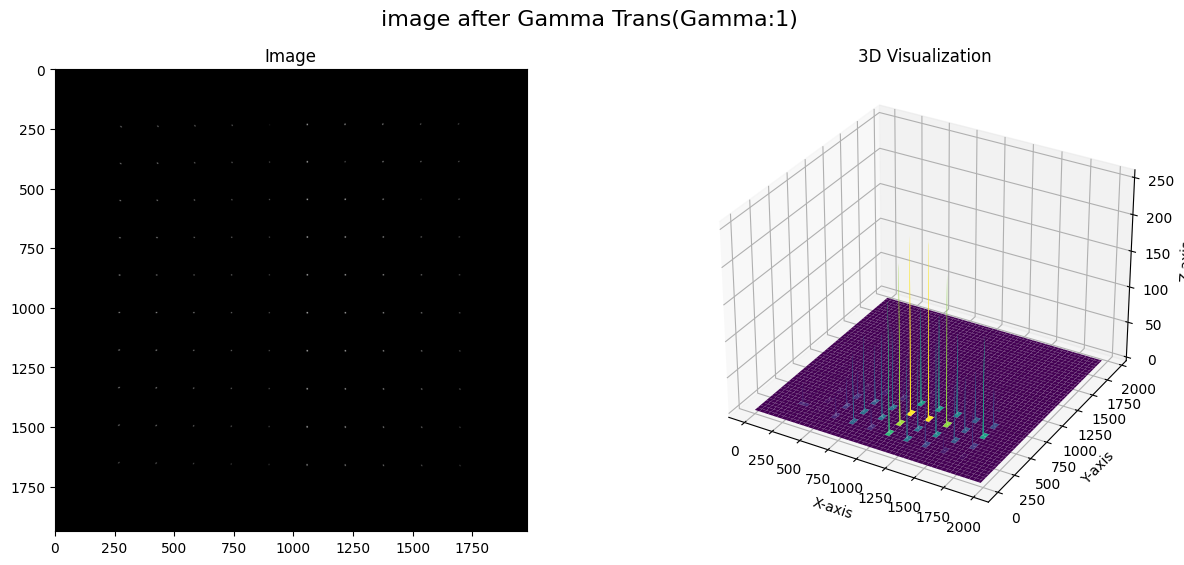

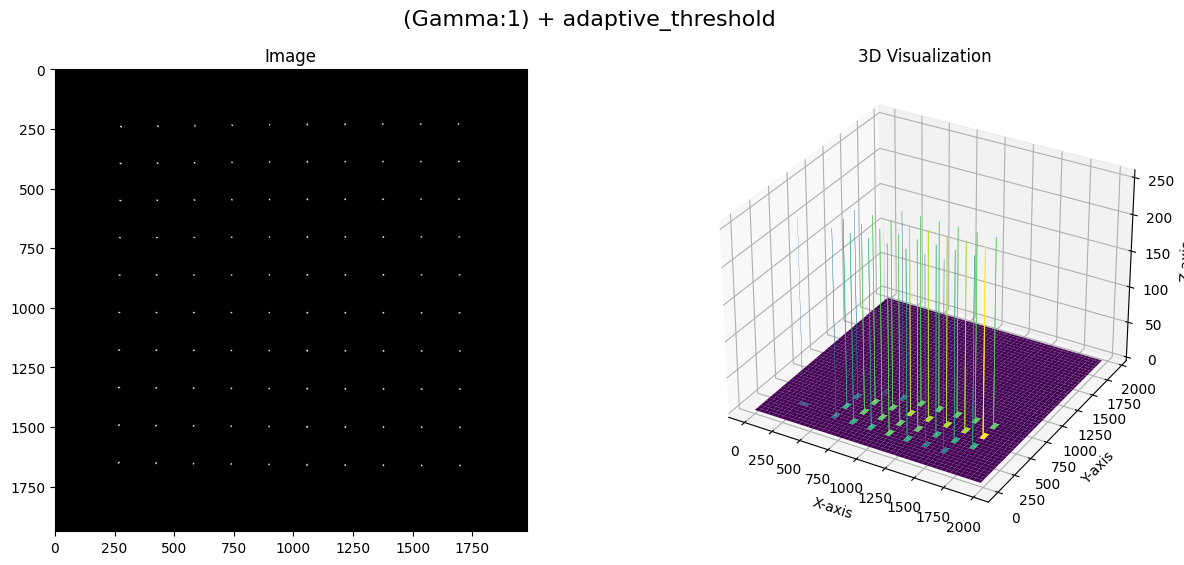

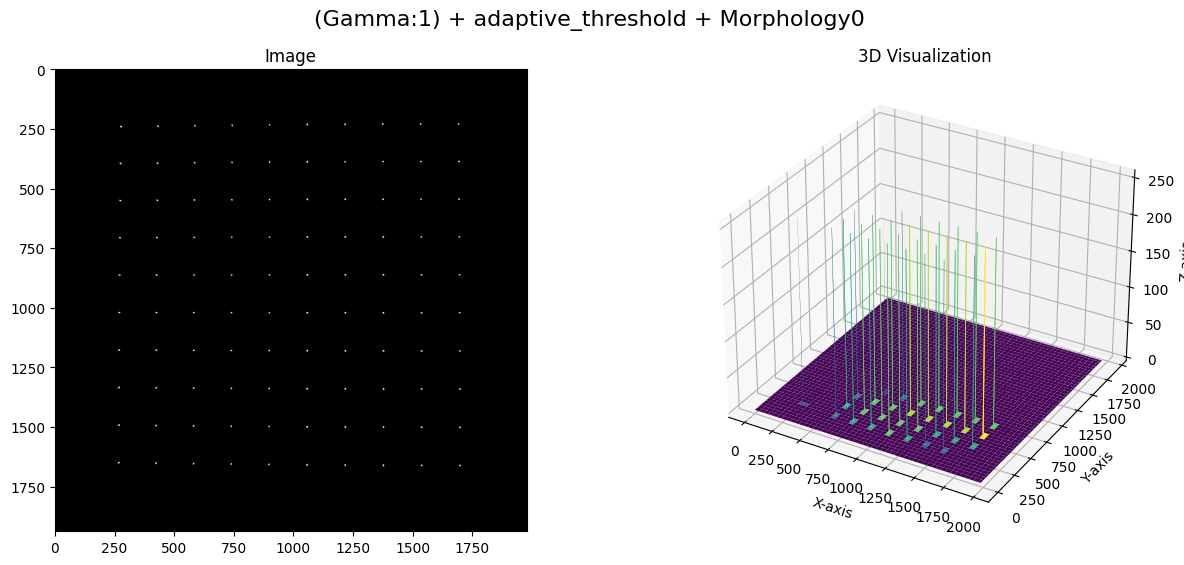

min_area_threshold = 5
max_area_threshold = 1000


error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\smooth.dispatch.cpp:617: error: (-215:Assertion failed) !_src.empty() in function 'cv::GaussianBlur'


In [82]:
from utils.findBrightRegions import findBrightRegions
# 1. 遍历文件夹中的文件
for filename in os.listdir(rawimgs_path):
    image_path = os.path.join(rawimgs_path, filename)
    # 2. 读取图像，寻找区域
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # 寻找亮区域
    num_labels, labels, stats, centroids = findBrightRegions(image, filename, attribute_dict)

    # 过滤面积超出阈值的连通区域
    min_area_threshold = 0 if int(attribute_dict["ExposureTime"]) < 1000 else 5
    max_area_threshold = 1000
    print(f"min_area_threshold = {min_area_threshold}")
    print(f"max_area_threshold = {max_area_threshold}")

    filtered_labels = [
        label
        for label, stat in enumerate(stats[1:], start=1)
        if min_area_threshold < stat[4] < max_area_threshold
    ]
    # 可视化找到的亮区域结果
    mask = np.zeros_like(image)
    for label in filtered_labels:
        mask[labels == label] = 255
        # 在图像上绘制文本, 标注面积
        area = stats[label][4]
        text = f"Area:{area}"
        text_size, _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
        # 计算文本框的位置
        centroid = (int(centroids[label][0]- text_size[0]/2), int(centroids[label][1]+ 1.2*text_size[1]))
        # 绘制文本
        cv2.putText(mask, text, centroid, cv2.FONT_HERSHEY_SIMPLEX, 1, 255, 2)
        
    rgba_array = np.zeros((*mask.shape, 4), dtype=np.uint8)
    rgba_array[:, :, 0] = mask  # 红色通道
    rgba_array[:, :, 3] = 100  # 透明度
    rgba_mask = Image.fromarray(rgba_array, "RGBA")
    rgba_image = Image.fromarray(image).convert("RGBA")
    rgba_result = Image.alpha_composite(rgba_image, rgba_mask)

    rgba_result_name = "Area Result of " + os.path.basename(image_path)
    output_path = os.path.join(folder_path, "result", rgba_result_name)
    rgba_result.save(output_path, "BMP")

    stats = stats[filtered_labels, :]
    
    # 获取图像的边长, 一张图中可以均分为10个竖条区域，区域内的针孔大小相同
    image_width = image.shape[0]
    region_width = image_width // 10
    
    # 3.裁剪区域，保存和记录特征值
    for stat in stats:
        # 获取连通区域的坐标信息,x,y是leftTop点坐标
        x, y, w, h, area = stat[0], stat[1], stat[2], stat[3], stat[4]

        from utils.getDiameterfromPosition import getDiameterfromPosition

        # 根据位置判断直径
        min_diameter = int(os.path.basename(image_path).split("_")[0])
        Diameter = getDiameterfromPosition(x, region_width, min_diameter)

        # 裁剪图像
        # # 根据长宽裁剪
        # cropped_region = image[y - 2 * h : y + 3 * h, x - 2 * w : x + 3 * w]
        # 按正方形裁剪
        length = 10* max(w, h)
        center = [x + w / 2, y + h / 2]
        cropped_region = image[
            int(center[1] - length / 2) : int(center[1] + length / 2),
            int(center[0] - length / 2) : int(center[0] + length / 2)
        ]

        # 计算最大值、最小值、平均值、中位数和方差
        max_value = np.max(cropped_region)
        min_value = np.min(cropped_region)
        mean_value = np.mean(cropped_region)
        median_value = np.median(cropped_region)
        variance_value = np.var(cropped_region)

        # 打开annotation.cvs记录
        with open(folder_path + "/annotation.csv", "r") as file:
            lines = file.readlines()
            last_image_id = 0
            if len(lines) > 1:  # 确保文件中有至少两行（包括标题行和数据行）
                last_line = lines[-1].strip()  # 获取最新一行并去除首尾空白
                last_image_id = int(last_line.split(",")[0])

        with open(folder_path + "/annotation.csv", "a") as file:
            file.write(
                f"{last_image_id + 1},"
                f"{attribute_dict['ImagingDistance']},"
                f"{attribute_dict['ExposureTime']},"
                f"{attribute_dict['PowerdividedbyArea']},"
                f"{attribute_dict['Fnumber']},"
                f"{attribute_dict['Focal']},"
                f"{attribute_dict['CMOSPixelSize']},"
                f"{attribute_dict['CMOSQE']},"
                f"{w},"
                f"{h},"
                f"{area},"
                # 图像的灰度分布信息：最值 平均值 中位数 方差
                f"{max_value:.4f},"
                f"{min_value:.4f},"
                f"{mean_value:.4f},"
                f"{median_value:.4f},"
                f"{variance_value:.4f},"
                f"{x},"
                f"{y},"
                f"{Diameter}\n"
            )
        # 保存裁剪的图像
        cv2.imwrite(
            os.path.join(output_folder, f"{last_image_id + 1}.png"),
            cropped_region,
        )